### Часть 1. Перенос стиля при помощи Pix2Pix

#### План работы:
- загрузка данных, нормализация
- создание обучающей выборки с размером батча 1
- создание генератора на основе Unet - автокодировщика, как в статье Isola et al.
- создание дискриминатора на основе блоков, как в статье Isola et al.
- обучение генератора и дискриминатора при помощи MSE и L1 функций потерь
- вывод сгенерированных изображений из валидационной выборки через каждые 10 эпох

Примечание: обучение проводилось в Google Colab, который прервал его на 35 эпохах возможно
из-за лимита времени. Из-за недостатка времени на обучение приходится ограничиться только 
этими результатами. Тем не менее, даже на этих результатах видно, что качество генерируемых
изображений улучшается.

In [ ]:
from os import listdir
import requests
import time
import tqdm
import datetime
import numpy as np
import tarfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as VF
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt

In [ ]:
open('facades', 'wb').write(requests.get('http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz').content)

31692800

In [ ]:
with tarfile.open('facades') as arch:
    arch.extractall('./images')

In [ ]:
# Функция для отображения и сохранения сгенирированных и настоящих изображений

def print_save_img(img, cnt):
    img = torch.cat((img[0], img[1], img[2]), -1)
    save_image(img, "images/%s.png" % ('facades_' + str(cnt)), nrow=5, normalize=True)
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)

    t_mean = torch.FloatTensor(mean).view(3,1,1).expand(3, 256, 256 * 3)
    t_std = torch.FloatTensor(std).view(3,1,1).expand(3, 256, 256 * 3)

    img_GT = img * t_std + t_mean

    img = transforms.ToPILImage()(img_GT).convert('RGB')
    resize = transforms.Resize(200)
    img = resize(img)
    display(img)

In [ ]:
# Создание датасетов и даталодеров

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder('train_images', transform=transform)
val_dataset = datasets.ImageFolder('validation_images', transform=transform)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

In [ ]:
for batch in dataloader:
    break

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Сети генератора и дискриминатора

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class GenEncoder(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(GenEncoder, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class GenDecoder(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(GenDecoder, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = GenEncoder(in_channels, 64, normalize=False)
        self.down2 = GenEncoder(64, 128)
        self.down3 = GenEncoder(128, 256)
        self.down4 = GenEncoder(256, 512, dropout=0.5)
        self.down5 = GenEncoder(512, 512, dropout=0.5)
        self.down6 = GenEncoder(512, 512, dropout=0.5)
        self.down7 = GenEncoder(512, 512, dropout=0.5)
        self.down8 = GenEncoder(512, 512, normalize=False, dropout=0.5)

        self.up1 = GenDecoder(512, 512, dropout=0.5)
        self.up2 = GenDecoder(1024, 512, dropout=0.5)
        self.up3 = GenDecoder(1024, 512, dropout=0.5)
        self.up4 = GenDecoder(1024, 512, dropout=0.5)
        self.up5 = GenDecoder(1024, 256)
        self.up6 = GenDecoder(512, 128)
        self.up7 = GenDecoder(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch 0/50] [D loss: 0.243300] [G loss: 23.661699, pixel: 0.228657, adv: 0.796040]


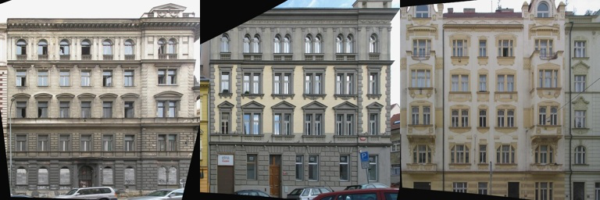

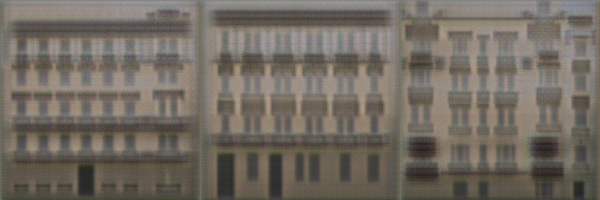

  4%|▍         | 2/50 [27:33<11:00:01, 825.03s/it]

[Epoch 1/50] [D loss: 0.148944] [G loss: 22.458145, pixel: 0.215959, adv: 0.862224]


  6%|▌         | 3/50 [41:10<10:43:44, 821.79s/it]

[Epoch 2/50] [D loss: 0.124055] [G loss: 22.490261, pixel: 0.214890, adv: 1.001259]


  8%|▊         | 4/50 [54:48<10:28:36, 819.92s/it]

[Epoch 3/50] [D loss: 0.092860] [G loss: 21.414522, pixel: 0.204288, adv: 0.985700]


 10%|█         | 5/50 [1:08:29<10:15:20, 820.46s/it]

[Epoch 4/50] [D loss: 0.079032] [G loss: 21.015699, pixel: 0.201196, adv: 0.896063]


 12%|█▏        | 6/50 [1:22:09<10:01:36, 820.37s/it]

[Epoch 5/50] [D loss: 0.056650] [G loss: 21.041965, pixel: 0.202065, adv: 0.835509]


 14%|█▍        | 7/50 [1:35:51<9:48:18, 820.91s/it] 

[Epoch 6/50] [D loss: 0.054850] [G loss: 21.386644, pixel: 0.204998, adv: 0.886839]


 16%|█▌        | 8/50 [1:49:29<9:33:50, 819.78s/it]

[Epoch 7/50] [D loss: 0.082296] [G loss: 20.736357, pixel: 0.196746, adv: 1.061720]


 18%|█▊        | 9/50 [2:03:06<9:19:42, 819.09s/it]

[Epoch 8/50] [D loss: 0.060687] [G loss: 20.913008, pixel: 0.199994, adv: 0.913617]


 20%|██        | 10/50 [2:16:45<9:06:06, 819.17s/it]

[Epoch 9/50] [D loss: 0.107655] [G loss: 21.521263, pixel: 0.203953, adv: 1.126001]
[Epoch 10/50] [D loss: 0.041854] [G loss: 20.683704, pixel: 0.196151, adv: 1.068607]


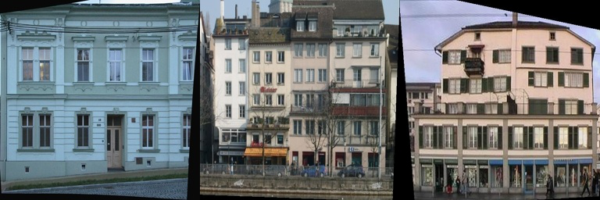

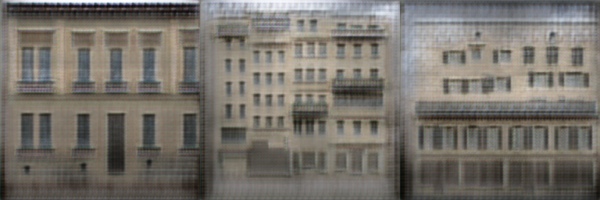

 24%|██▍       | 12/50 [2:44:26<8:42:27, 824.93s/it]

[Epoch 11/50] [D loss: 0.079912] [G loss: 20.612577, pixel: 0.195562, adv: 1.056392]


 26%|██▌       | 13/50 [2:58:13<8:29:03, 825.49s/it]

[Epoch 12/50] [D loss: 0.043891] [G loss: 20.338625, pixel: 0.192925, adv: 1.046126]


 28%|██▊       | 14/50 [3:11:59<8:15:30, 825.84s/it]

[Epoch 13/50] [D loss: 0.181955] [G loss: 20.099213, pixel: 0.188813, adv: 1.217935]


 30%|███       | 15/50 [3:25:46<8:01:52, 826.06s/it]

[Epoch 14/50] [D loss: 0.149269] [G loss: 19.723381, pixel: 0.185076, adv: 1.215745]


 32%|███▏      | 16/50 [3:39:31<7:47:51, 825.64s/it]

[Epoch 15/50] [D loss: 0.153195] [G loss: 20.577888, pixel: 0.192674, adv: 1.310532]


 34%|███▍      | 17/50 [3:53:13<7:33:31, 824.58s/it]

[Epoch 16/50] [D loss: 0.204595] [G loss: 20.833481, pixel: 0.194472, adv: 1.386261]


 36%|███▌      | 18/50 [4:07:01<7:20:21, 825.66s/it]

[Epoch 17/50] [D loss: 0.120672] [G loss: 20.719442, pixel: 0.192698, adv: 1.449666]


 38%|███▊      | 19/50 [4:20:44<7:06:08, 824.78s/it]

[Epoch 18/50] [D loss: 0.011808] [G loss: 20.319044, pixel: 0.193047, adv: 1.014357]


 40%|████      | 20/50 [4:34:25<6:51:55, 823.86s/it]

[Epoch 19/50] [D loss: 0.028126] [G loss: 19.960115, pixel: 0.188870, adv: 1.073160]
[Epoch 20/50] [D loss: 0.004036] [G loss: 20.173820, pixel: 0.192198, adv: 0.953975]


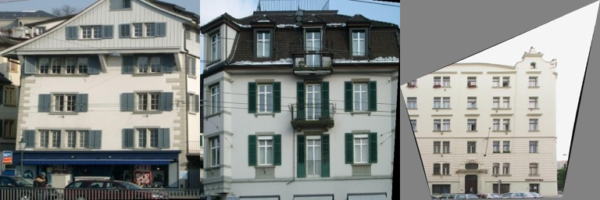

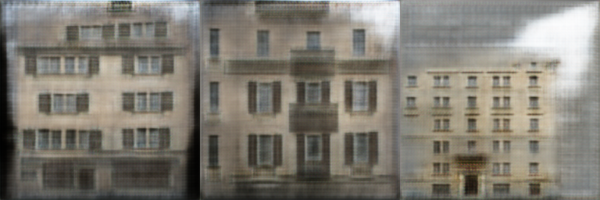

 44%|████▍     | 22/50 [5:02:00<6:25:22, 825.79s/it]

[Epoch 21/50] [D loss: 0.007021] [G loss: 19.589964, pixel: 0.186337, adv: 0.956252]


 46%|████▌     | 23/50 [5:15:52<6:12:30, 827.81s/it]

[Epoch 22/50] [D loss: 0.011356] [G loss: 19.403090, pixel: 0.184520, adv: 0.951068]


 48%|████▊     | 24/50 [5:29:50<5:59:59, 830.75s/it]

[Epoch 23/50] [D loss: 0.129833] [G loss: 19.468199, pixel: 0.180693, adv: 1.398866]


 50%|█████     | 25/50 [5:43:48<5:47:00, 832.83s/it]

[Epoch 24/50] [D loss: 0.005179] [G loss: 18.390982, pixel: 0.174459, adv: 0.945089]


 52%|█████▏    | 26/50 [5:57:43<5:33:27, 833.66s/it]

[Epoch 25/50] [D loss: 0.002737] [G loss: 19.012253, pixel: 0.179972, adv: 1.015100]


 54%|█████▍    | 27/50 [6:11:38<5:19:39, 833.87s/it]

[Epoch 26/50] [D loss: 0.003913] [G loss: 17.940722, pixel: 0.169778, adv: 0.962939]


 56%|█████▌    | 28/50 [6:25:39<5:06:34, 836.11s/it]

[Epoch 27/50] [D loss: 0.003784] [G loss: 19.402895, pixel: 0.184269, adv: 0.976030]


 58%|█████▊    | 29/50 [6:39:37<4:52:48, 836.59s/it]

[Epoch 28/50] [D loss: 0.003174] [G loss: 18.623869, pixel: 0.176526, adv: 0.971286]


 60%|██████    | 30/50 [6:53:33<4:38:48, 836.44s/it]

[Epoch 29/50] [D loss: 0.003259] [G loss: 18.939417, pixel: 0.179654, adv: 0.973986]
[Epoch 30/50] [D loss: 0.003462] [G loss: 18.260626, pixel: 0.172851, adv: 0.975489]


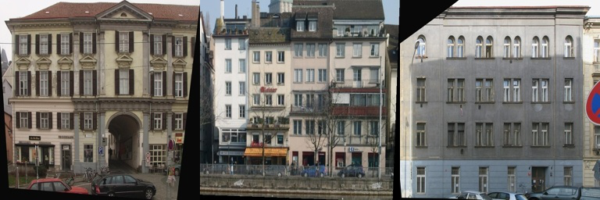

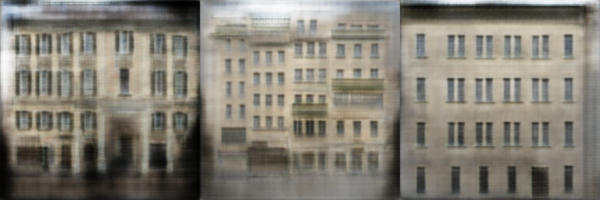

 64%|██████▍   | 32/50 [7:21:21<4:10:27, 834.87s/it]

[Epoch 31/50] [D loss: 0.003532] [G loss: 17.984442, pixel: 0.169773, adv: 1.007113]


 66%|██████▌   | 33/50 [7:35:06<3:55:43, 831.99s/it]

[Epoch 32/50] [D loss: 0.002098] [G loss: 17.377785, pixel: 0.163676, adv: 1.010165]


 68%|██████▊   | 34/50 [7:48:51<3:41:17, 829.82s/it]

[Epoch 33/50] [D loss: 0.010327] [G loss: 19.015429, pixel: 0.180104, adv: 1.005002]


 70%|███████   | 35/50 [8:02:37<3:27:12, 828.83s/it]

[Epoch 34/50] [D loss: 0.001933] [G loss: 18.140800, pixel: 0.171852, adv: 0.955582]


In [ ]:
# Функции потерь
criterion_GAN = torch.nn.MSELoss().to(device)
criterion_pixelwise = torch.nn.L1Loss().to(device)

# Выход дискриминатора (PatchGAN)
patch = (1, 16, 16)

# Модели и инициализация весами
generator = GeneratorUNet()
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Оптимизаторы
optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

def set_requires_grad(net, req_grad):
    for param in net.parameters():
        param.requires_grad = req_grad

n_epochs = 50

for epoch in tqdm.tqdm(range(n_epochs)):
    for i, batch in enumerate(dataloader):

        # Входные данные
        real_A = batch[0][:, :, :, 256:]
        real_B = batch[0][:, :, :, :256]
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        valid = Variable(torch.tensor(np.ones((real_A.size(0), *patch)), dtype=torch.float), requires_grad=False)
        valid = valid.to(device)
        fake = Variable(torch.tensor(np.zeros((real_A.size(0), *patch)), dtype=torch.float), requires_grad=False)
        fake = fake.to(device)

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)
        pred_fake = discriminator(fake_B, real_A)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Функция потерь генератора
        loss_G = loss_GAN + 100 * loss_pixel

        loss_G.backward()

        # Шаг оптимизатора изолированно только по генератору
        set_requires_grad(discriminator, False)
        optimizer_G.step()
        set_requires_grad(discriminator, True)

        optimizer_D.zero_grad()
        
        # Функции потерь дискриминатора

        pred_real = discriminator(real_B, real_A)
        loss_real = criterion_GAN(pred_real, valid)

        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # Логирование
    print(
        "\r[Epoch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f]"
        % (
            epoch,
            n_epochs,
            loss_D.item(),
            loss_G.item(),
            loss_pixel.item(),
            loss_GAN.item(),
        )
        )

    if epoch % 10 == 0:
        imgs = next(iter(val_dataloader))
        ix = np.random.randint(0, len(val_dataset), 3).tolist()
        real_A = imgs[0][ix, :, :, 256:]
        real_B = imgs[0][ix, :, :, :256]
        fake_B = generator(real_A)
        print_save_img(real_B, epoch // 10)
        print_save_img(fake_B, epoch // 10)
        torch.save(generator.state_dict(), 'generator_' + str(epoch // 10))